C:\Users\anush\AppData\Local\Temp\ipykernel_38256\3684241049.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Jerk'].fillna(0, inplace=True)  # Fill NaN values with 0


        Latitude  Longitude  Speed  Acceleration  Jerk  Driving_Score  \
0      39.980572 -82.953895     29          0.00  0.00          100.0   
1      39.980575 -82.953735     29         -0.28 -0.28          100.0   
2      39.980582 -82.953587     24         -1.94 -1.66          100.0   
3      39.980602 -82.953477     21         -1.39  0.55          100.0   
4      39.980603 -82.953347     20         -0.56  0.83          100.0   
...          ...        ...    ...           ...   ...            ...   
47841  40.108798 -83.178652     41         -0.83 -0.27           45.0   
47842  40.108958 -83.178678     39         -1.11 -0.28           55.0   
47843  40.109107 -83.178703     36         -1.11  0.00           70.0   
47844  40.109245 -83.178727     33         -1.39 -0.28           85.0   
47845  40.109367 -83.178745     29         -1.67 -0.28          100.0   

      Driving_Category  
0                 Safe  
1                 Safe  
2                 Safe  
3                 Safe 

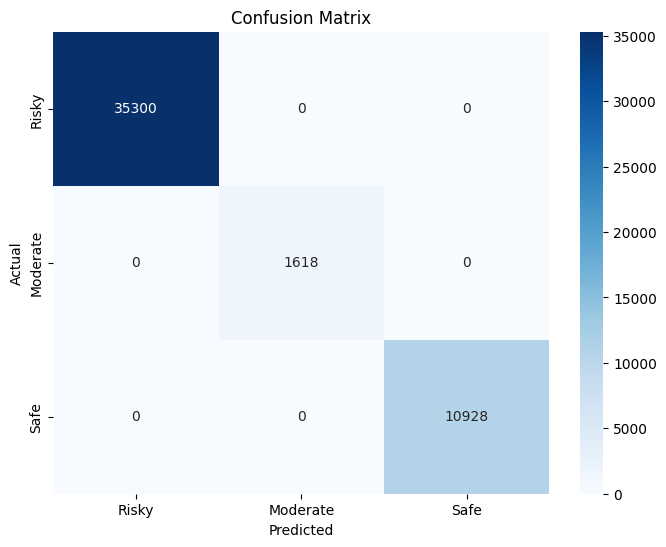

Feature ranking:
1. feature Speed (0.5575062553631189)
2. feature Speed_Violation (0.39405086233097886)
3. feature High_Heading_Change (0.023192888492741842)
4. feature Acceleration (0.01932561236886209)
5. feature Jerk (0.003843157041985798)
6. feature Sensitive_Area_Violation (0.0020707482142832377)
7. feature Harsh_Braking (1.0005981162288131e-05)
8. feature Harsh_Acceleration (4.702068669886128e-07)
9. feature High_Jerk (0.0)


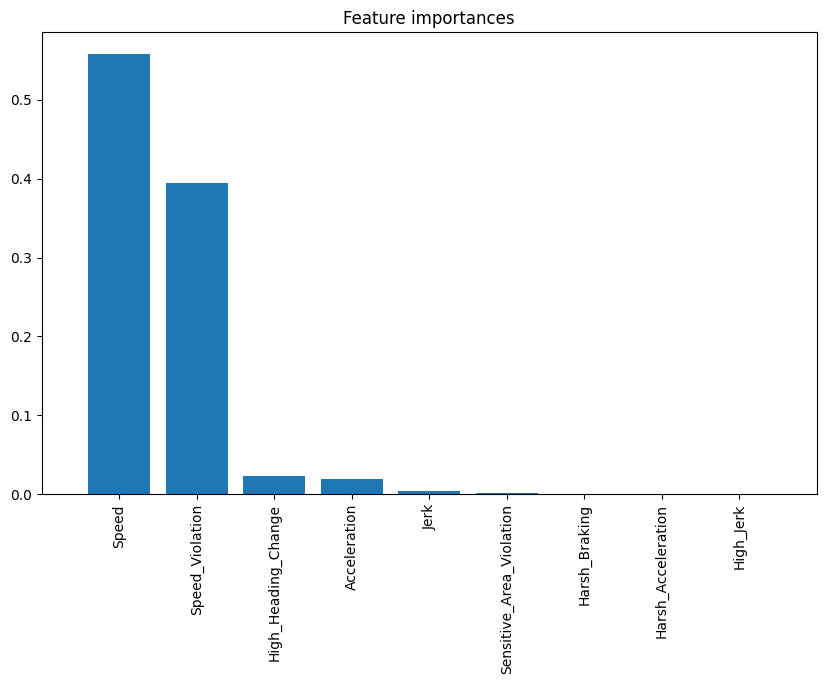

In [8]:
import os
import pandas as pd
import numpy as np
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib  # For saving the model

# Load sensitive locations
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

def analyze_driving_data(df):
    """Analyzes driving data based on absolute metrics."""
    
    # Define thresholds
    speed_limit = 30  # Speed limit in km/h
    harsh_acceleration_threshold = 3.0  # Harsh acceleration in m/s^2
    harsh_braking_threshold = -3.0  # Harsh braking in m/s^2
    jerk_threshold = 5.0  # Jerk threshold in m/s^3
    heading_change_threshold = 30.0  # Heading change threshold in degrees

    # Initialize columns
    df['Jerk'] = 0.0  # Initialize Jerk column
    df['Driving_Score'] = 100  # Start with a maximum score

    # Calculate Jerk (change in acceleration over change in time)
    df['Jerk'] = df['Acceleration'].diff() / df['TimeStep'].diff()  # m/s^3
    df['Jerk'].fillna(0, inplace=True)  # Fill NaN values with 0

    # Calculate penalties based on thresholds
    df['Speed_Violation'] = np.where(df['Speed'] > speed_limit, (df['Speed'] - speed_limit) * 5, 0)
    df['Harsh_Acceleration'] = np.where(df['Acceleration'] > harsh_acceleration_threshold, (df['Acceleration'] - harsh_acceleration_threshold) * 5, 0)
    df['Harsh_Braking'] = np.where(df['Acceleration'] < harsh_braking_threshold, (harsh_braking_threshold - df['Acceleration']) * 2, 0)
    df['High_Jerk'] = np.where(abs(df['Jerk']) > jerk_threshold, abs(df['Jerk'] - jerk_threshold) * 5, 0)
    df['High_Heading_Change'] = np.where(abs(df['HeadingChange']) > heading_change_threshold, abs(df['HeadingChange'] - heading_change_threshold) * 5, 0)

    # Deduct points for violations
    df['Driving_Score'] -= df['Speed_Violation'] + df['Harsh_Acceleration'] + df['Harsh_Braking'] + df['High_Jerk'] + df['High_Heading_Change']

    # Calculate the distance to sensitive locations and check for violations
    df['Sensitive_Area_Violation'] = 0
    for index, row in df.iterrows():
        driver_location = (row['Latitude'], row['Longitude'])
        for _, loc in sensitive_locations.iterrows():
            sensitive_location = (loc['Latitude'], loc['Longitude'])
            distance = haversine(driver_location, sensitive_location, unit=Unit.METERS)
            if distance <= 300 and row['Speed'] > (speed_limit * 1000 / 3600):  # Speed limit in m/s
                df.at[index, 'Sensitive_Area_Violation'] = 1
                break  # No need to check further if one violation is found
    df['Driving_Score'] -= df['Sensitive_Area_Violation'] * 10  # Deduct points for violations near sensitive areas

    # Categorize driving behavior
    def categorize_driving(score):
        if score >= 80:
            return 'Safe'
        elif 60 <= score < 80:
            return 'Moderate'
        else:
            return 'Risky'

    df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving)

    return df

# Load driving data
driving_data = pd.read_csv('../data/driving_data.csv')

# Analyze driving data
analyzed_data = analyze_driving_data(driving_data)

# Save the analyzed data for further use
analyzed_data.to_csv('../data/analyzed_driving_data.csv', index=False)

# Display results
print(analyzed_data[['Latitude', 'Longitude', 'Speed', 'Acceleration', 'Jerk', 'Driving_Score', 'Driving_Category']])

# Prepare data for model training
features = ['Speed', 'Acceleration', 'Jerk', 'High_Jerk', 'Speed_Violation', 'Harsh_Acceleration', 
            'Harsh_Braking', 'Sensitive_Area_Violation', 'High_Heading_Change']
target = 'Driving_Category'

X = analyzed_data[features]
y = analyzed_data[target]

# Convert categorical variable to numerical
y = y.map({'Safe': 2, 'Moderate': 1, 'Risky': 0})

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
results = []

# Train the Random Forest Classifier with hyperparameter tuning
model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=kf, 
                            scoring='accuracy', random_state=42, n_jobs=-1)

# Fit the model
search.fit(X, y)

# Best model
best_model = search.best_estimator_

# Save the model parameters alongside the model
model_params = search.best_params_
joblib.dump({'model': best_model, 'params': model_params}, '../models/driving_model_with_params.pkl')

# Predictions
y_pred = best_model.predict(X)

# Evaluate the model
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the model
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
